#### Chapter 27
### Analyzing Neural Time Series Data
Python code for Chapter 27 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

### Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kstest, rankdata
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy.signal import correlate, correlation_lags

### An aside on covariance and correlation

In [ ]:
a = np.random.randn(100)
b = np.random.randn(100)

corr1 = np.corrcoef(a, b)[0, 1]

a1 = a - np.mean(a)
b1 = b - np.mean(b)
corr2 = (a1 @ b1.T) / np.sqrt((a1 @ a1.T) * (b1 @ b1.T))

c = np.vstack((a1, b1))
covmat = c @ c.T

# notice the following:
print(covmat[0, 0] == a1 @ a1.T)
print(covmat[1, 1] == b1 @ b1.T)
print(covmat[1, 0] == a1 @ b1.T)
# actually, some of these might not be exactly equal due to very small computer rounding errors.
# try this instead:
print((covmat[1, 0] - a1 @ b1.T) < 1e-14)

corr3 = covmat[0, 1] / np.sqrt(covmat[0, 0] * covmat[1, 1])

print(f"\nPython numpy.corrcoef function: {corr1}")
print(f"covariance scaled by variances: {corr2}")
print(f"covariance computed as matrix: {corr3}\n")

False
False
False
True

Python numpy.corrcoef function: -0.18111792542261373
covariance scaled by variances: -0.18111792542261368
covariance computed as matrix: -0.18111792542261373



### Figure 27.1

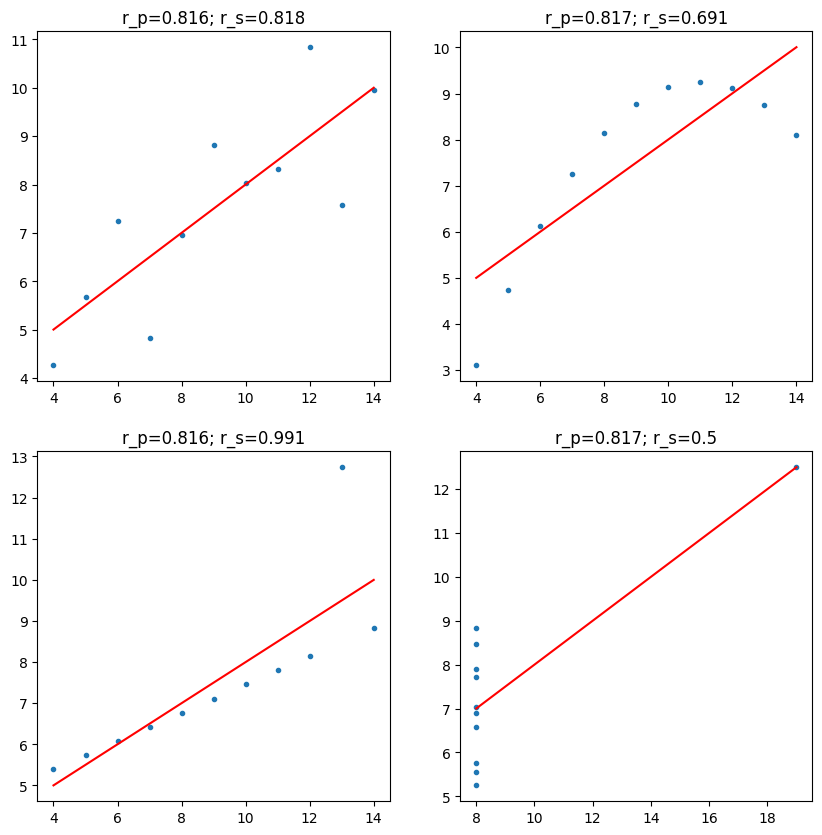

In [ ]:
anscombe = np.array([
    # series 1    series 2    series 3     series 4
    [10, 8.04,    10, 9.14,    10, 7.46,     8, 6.58],
    [8, 6.95,     8, 8.14,     8, 6.77,     8, 5.76],
    [13, 7.58,    13, 8.76,    13, 12.74,    8, 7.71],
    [9, 8.81,     9, 8.77,     9, 7.11,     8, 8.84],
    [11, 8.33,    11, 9.26,    11, 7.81,     8, 8.47],
    [14, 9.96,    14, 8.10,    14, 8.84,     8, 7.04],
    [6, 7.24,     6, 6.13,     6, 6.08,     8, 5.25],
    [4, 4.26,     4, 3.10,     4, 5.39,     8, 5.56],
    [12, 10.84,   12, 9.13,    12, 8.15,     8, 7.91],
    [7, 4.82,     7, 7.26,     7, 6.42,     8, 6.89],
    [5, 5.68,     5, 4.74,     5, 5.73,    19, 12.50],
])

# plot and compute correlations
plt.figure(figsize=(10, 10))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    x = anscombe[:, (i - 1) * 2]
    y = anscombe[:, (i - 1) * 2 + 1]
    plt.plot(x, y, '.')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
    corr_p, _ = pearsonr(x, y)
    corr_s, _ = spearmanr(x, y)
    plt.title(f'r_p={round(corr_p, 3)}; r_s={round(corr_s, 3)}')
plt.show()

### Figure 27.2

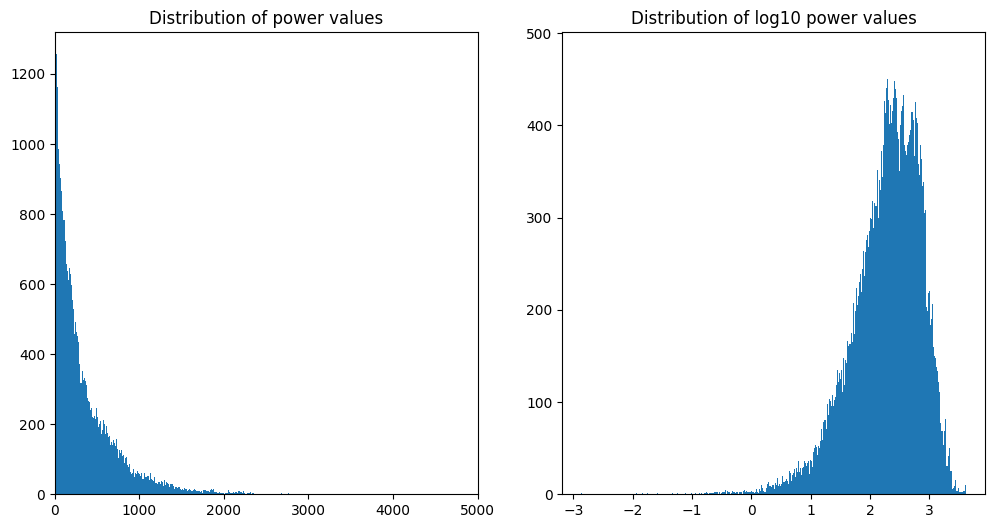

KS test for normality of power: 0.0 (>.05 means normal distribution)
KS test for normality of log10(power): 0.0 (>.05 means normal distribution)
KS test for normality of random data: 0.6439599564317877 (>.05 means normal distribution)


In [ ]:
# Load EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

sensor2use = 'Fz'
centerfreq = 10  # in Hz

# setup wavelet convolution and outputs
time = np.arange(-1, 1 + 1/EEG['srate'][0, 0], 1/EEG['srate'][0, 0])
half_of_wavelet_size = (len(time) - 1) // 2

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1
wavelet_cycles = 4.5


# FFT of data (note: this doesn't change on frequency iteration)
fft_data = fft(EEG['data'][EEG['chanlocs'][0]['labels']==sensor2use, :, :].flatten('F'), n_convolution)

# create wavelet and run convolution
fft_wavelet = fft(np.exp(2 * 1j * np.pi * centerfreq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq)) ** 2)), n_convolution)
convolution_result_fft = ifft(fft_wavelet * fft_data, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq))
convolution_result_fft = convolution_result_fft[half_of_wavelet_size: -half_of_wavelet_size]
convolution_result_fft = np.abs(np.reshape(convolution_result_fft, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# trim edges so the distribution is not driven by edge artifact outliers
convolution_result_fft = convolution_result_fft[99:-100, :]

# plot distribution of power data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(convolution_result_fft.flatten('F'), bins=500)
plt.xlim([0, 5000])
plt.title('Distribution of power values')

plt.subplot(122)
plt.hist(np.log10(convolution_result_fft.flatten('F')), bins=500)
plt.title('Distribution of log10 power values')
plt.show()

# test for normal distribution, if you have the stats toolbox
if 'kstest' in dir():
    p1 = kstest(convolution_result_fft.flatten('F'), 'norm')[1]
    p2 = kstest(np.log10(convolution_result_fft.flatten('F')), 'norm')[1]
    p3 = kstest(np.random.randn(convolution_result_fft.size), 'norm')[1]
    print(f'KS test for normality of power: {p1} (>.05 means normal distribution)')
    print(f'KS test for normality of log10(power): {p2} (>.05 means normal distribution)')
    print(f'KS test for normality of random data: {p3} (>.05 means normal distribution)')

### Figure 27.3

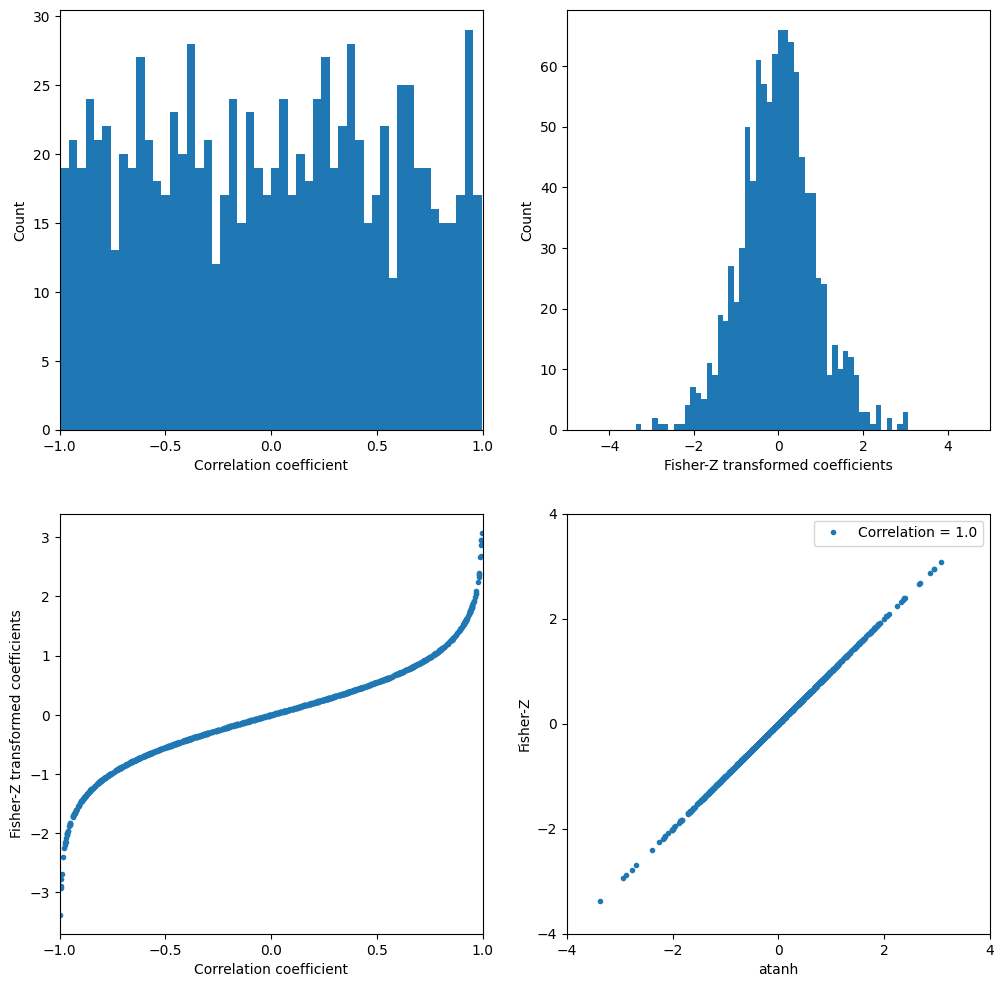

In [ ]:
# Fisher Z transformation
lots_of_corr_coefs = np.random.rand(1000) * 2 - 1
fisher_z_coefs = 0.5 * np.log((1 + lots_of_corr_coefs) / (1 - lots_of_corr_coefs))

plt.figure(figsize=(12, 12))

# Histogram of correlation coefficients
plt.subplot(221)
plt.hist(lots_of_corr_coefs, 50)
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')
plt.xlim([-1, 1])
plt.xticks(np.arange(-1, 1.5, 0.5))

# Histogram of Fisher-Z transformed coefficients
plt.subplot(222)
plt.hist(fisher_z_coefs, 50)
plt.xlabel('Fisher-Z transformed coefficients')
plt.ylabel('Count')
plt.xlim([-5, 5])
plt.xticks(np.arange(-4, 5, 2))

# Scatter plot of correlation coefficients vs. Fisher-Z transformed coefficients
plt.subplot(223)
plt.plot(lots_of_corr_coefs, fisher_z_coefs, '.')
plt.xlabel('Correlation coefficient')
plt.ylabel('Fisher-Z transformed coefficients')
plt.xlim([-1, 1])
plt.xticks(np.arange(-1, 1.5, 0.5))

# Scatter plot of atanh (inverse Fisher-Z) vs. Fisher-Z
plt.subplot(224)
plt.plot(np.arctanh(lots_of_corr_coefs), fisher_z_coefs, '.')
plt.xlabel('atanh')
plt.ylabel('Fisher-Z')
r = np.corrcoef(np.arctanh(lots_of_corr_coefs), fisher_z_coefs)[0, 1]
plt.legend([f'Correlation = {r}'])
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 5, 2))
plt.axis([-4, 4, -4, 4])
plt.show()

### Figure 27.4

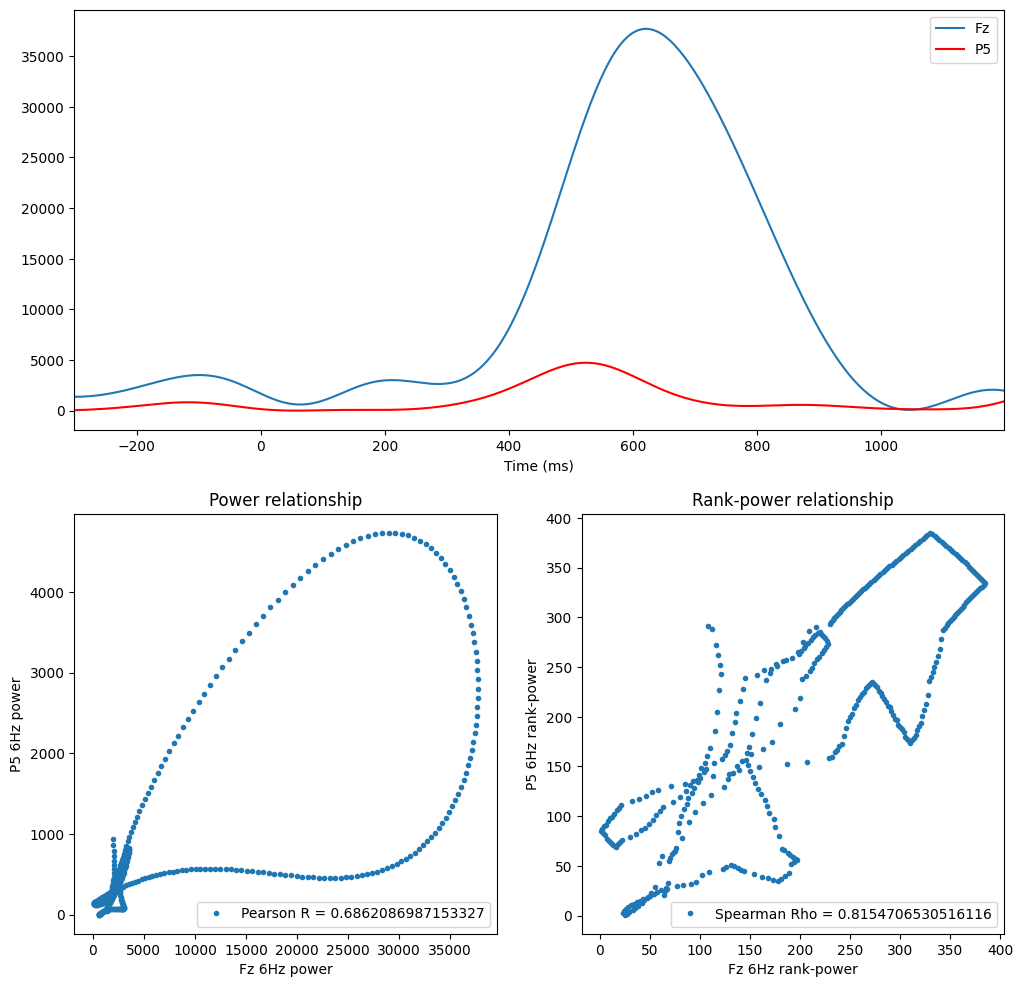

In [ ]:
# Define sensors and frequencies
sensor1 = 'Fz'
sensor2 = 'P5'

centerfreq = 6  # in Hz
trial2plot = 10 - 1 # subtract 1 because Python is 0-indexed

# Keep only requested time regions
times2plot_idx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in [-300, 1200]])

# FFT of data for both sensors
fft_data1 = fft(EEG['data'][EEG['chanlocs'][0]['labels']==sensor1, :, :].flatten('F'), n_convolution)
fft_data2 = fft(EEG['data'][EEG['chanlocs'][0]['labels']==sensor2, :, :].flatten('F'), n_convolution)

# Create wavelet and run convolution for both sensors
fft_wavelet = fft(np.exp(2 * 1j * np.pi * centerfreq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq)) ** 2)), n_convolution)

# Convolution for sensor 1
convolution_result_fft1 = ifft(fft_wavelet * fft_data1, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq))
convolution_result_fft1 = convolution_result_fft1[half_of_wavelet_size: -half_of_wavelet_size]
convolution_result_fft1 = np.abs(np.reshape(convolution_result_fft1, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# Convolution for sensor 2
convolution_result_fft2 = ifft(fft_wavelet * fft_data2, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq))
convolution_result_fft2 = convolution_result_fft2[half_of_wavelet_size: -half_of_wavelet_size]
convolution_result_fft2 = np.abs(np.reshape(convolution_result_fft2, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

convolution_result_fft1 = convolution_result_fft1[times2plot_idx[0]:times2plot_idx[1] + 1, :]
convolution_result_fft2 = convolution_result_fft2[times2plot_idx[0]:times2plot_idx[1] + 1, :]

# Plotting the power values and their relationship
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(EEG['times'][0][times2plot_idx[0]:times2plot_idx[1] + 1], convolution_result_fft1[:, trial2plot])
plt.plot(EEG['times'][0][times2plot_idx[0]:times2plot_idx[1] + 1], convolution_result_fft2[:, trial2plot], 'r')
plt.xlabel('Time (ms)')
plt.xlim(EEG['times'][0][times2plot_idx])
plt.legend([sensor1, sensor2])

plt.subplot(223)
plt.plot(convolution_result_fft1[:, trial2plot], convolution_result_fft2[:, trial2plot], '.')
plt.title('Power relationship')
plt.xlabel(f'{sensor1} {centerfreq}Hz power')
plt.ylabel(f'{sensor2} {centerfreq}Hz power')
r = np.corrcoef(convolution_result_fft1[:, trial2plot], convolution_result_fft2[:, trial2plot])[0, 1]
plt.legend([f'Pearson R = {r}'])

plt.subplot(224)
plt.plot(rankdata(convolution_result_fft1[:, trial2plot]), rankdata(convolution_result_fft2[:, trial2plot]), '.')
plt.title('Rank-power relationship')
plt.xlabel(f'{sensor1} {centerfreq}Hz rank-power')
plt.ylabel(f'{sensor2} {centerfreq}Hz rank-power')
r_spearman = spearmanr(convolution_result_fft1[:, trial2plot], convolution_result_fft2[:, trial2plot])[0]
plt.legend([f'Spearman Rho = {r_spearman}'])
plt.ylim(plt.xlim())
plt.show()

### Figure 27.5

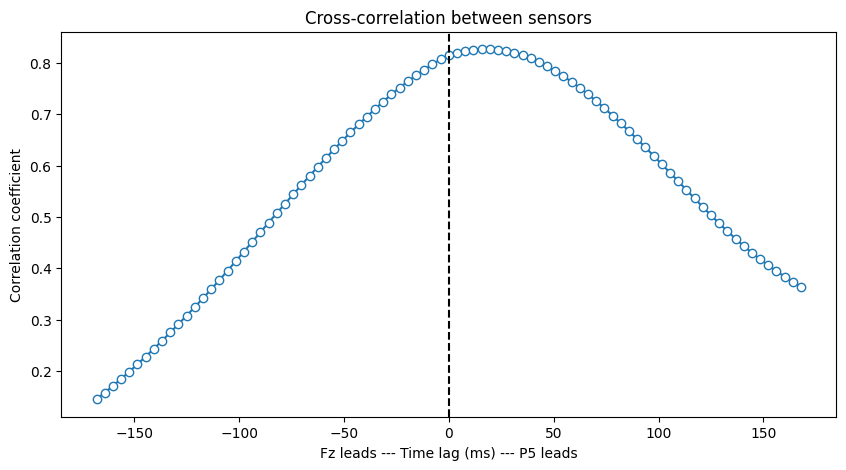

In [ ]:
# Compute how many time points are in one cycle, and limit xcov to this lag
nlags = round(EEG['srate'][0][0] / centerfreq)

# Rank transform the power values
rank_power1 = rankdata(np.abs(convolution_result_fft1[:, trial2plot]) ** 2)
rank_power2 = rankdata(np.abs(convolution_result_fft2[:, trial2plot]) ** 2)

# Compute cross-correlation
corrvals = correlate(rank_power1 - np.mean(rank_power1), 
                            rank_power2 - np.mean(rank_power2), 
                            mode='full')

# Normalize the cross-correlation values to get correlation coefficients
corrvals /= np.sqrt(np.sum((rank_power1 - np.mean(rank_power1)) ** 2) * np.sum((rank_power2 - np.mean(rank_power2)) ** 2))

# Get lags and convert to milliseconds
lags = correlation_lags(len(rank_power1), len(rank_power2), mode='full')
corrlags = lags / EEG['srate'][0][0] * 1000

# Find the center index corresponding to zero lag
center_idx = np.where(lags == 0)[0][0]

# Plot the cross-correlation
plt.figure(figsize=(10, 5))
plt.plot(corrlags[center_idx - nlags:center_idx + nlags + 1], 
         corrvals[center_idx - nlags:center_idx + nlags + 1], '-o', markerfacecolor='w')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel(f'{sensor1} leads --- Time lag (ms) --- {sensor2} leads')
plt.ylabel('Correlation coefficient')
plt.title('Cross-correlation between sensors')
plt.show()

### Figure 27.6

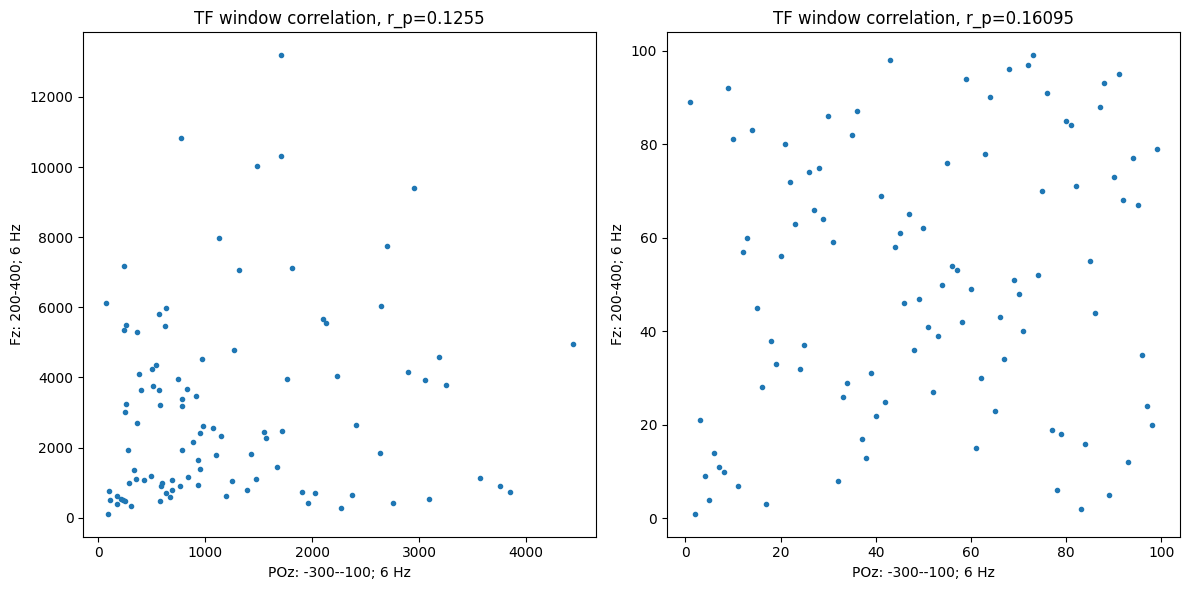

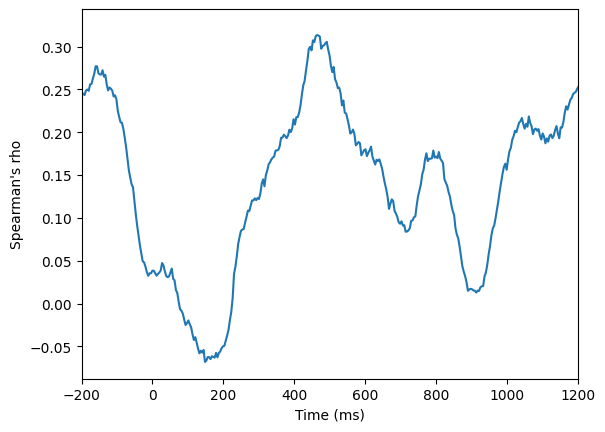

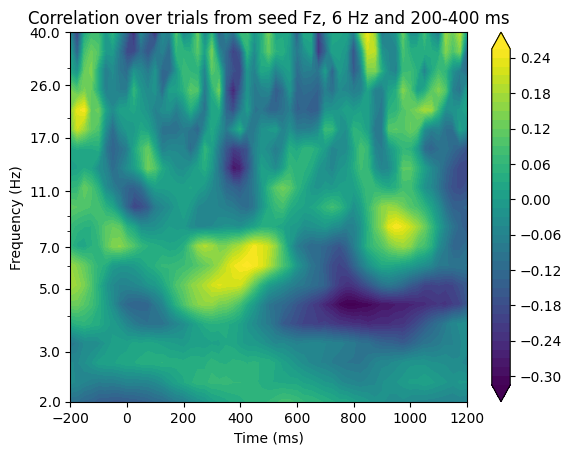

In [ ]:
# Define sensors and frequencies
sensor1 = 'POz'
sensor2 = 'Fz'

# Define time windows and frequencies
timewin1 = [-300, -100]  # in ms relative to stim onset
timewin2 = [200, 400]

centerfreq1 = 6  # in Hz
centerfreq2 = 6

# Convert time from ms to index
timeidx1 = [np.argmin(np.abs(EEG['times'][0] - t)) for t in timewin1]
timeidx2 = [np.argmin(np.abs(EEG['times'][0] - t)) for t in timewin2]

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1
wavelet_cycles = 4.5

# FFT of data for both sensors
fft_data1 = fft(EEG['data'][EEG['chanlocs'][0]['labels']==sensor1, :, :].flatten('F'), n_convolution)
fft_data2 = fft(EEG['data'][EEG['chanlocs'][0]['labels']==sensor2, :, :].flatten('F'), n_convolution)

# Create wavelet and run convolution for both sensors
fft_wavelet1 = fft(np.exp(2 * 1j * np.pi * centerfreq1 * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq1)) ** 2)), n_convolution)
convolution_result_fft1 = ifft(fft_wavelet1 * fft_data1, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq1))
convolution_result_fft1 = convolution_result_fft1[half_of_wavelet_size: -half_of_wavelet_size]
analyticsignal1 = np.abs(np.reshape(convolution_result_fft1, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

fft_wavelet2 = fft(np.exp(2 * 1j * np.pi * centerfreq2 * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq2)) ** 2)), n_convolution)
convolution_result_fft2 = ifft(fft_wavelet2 * fft_data2, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq2))
convolution_result_fft2 = convolution_result_fft2[half_of_wavelet_size: -half_of_wavelet_size]
analyticsignal2 = np.abs(np.reshape(convolution_result_fft2, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# Panel A: correlation in a specified window
tfwindowdata1 = np.mean(analyticsignal1[timeidx1[0]:timeidx1[1] + 1, :], axis=0)
tfwindowdata2 = np.mean(analyticsignal2[timeidx2[0]:timeidx2[1] + 1, :], axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(tfwindowdata1, tfwindowdata2, '.')
plt.title(f'TF window correlation, r_p={pearsonr(tfwindowdata1, tfwindowdata2)[0]:.4f}')
plt.xlabel(f'{sensor1}: {timewin1[0]}-{timewin1[1]}; {centerfreq1} Hz')
plt.ylabel(f'{sensor2}: {timewin2[0]}-{timewin2[1]}; {centerfreq2} Hz')

# Also plot rank-transformed data
plt.subplot(122)
plt.plot(rankdata(tfwindowdata1), rankdata(tfwindowdata2), '.')
plt.xlabel(f'{sensor1}: {timewin1[0]}-{timewin1[1]}; {centerfreq1} Hz')
plt.ylabel(f'{sensor2}: {timewin2[0]}-{timewin2[1]}; {centerfreq2} Hz')
plt.title(f'TF window correlation, r_p={spearmanr(tfwindowdata1, tfwindowdata2)[0]:.5f}')

plt.tight_layout()
plt.show()

# Panel B: correlation over time
corr_ts = np.array([spearmanr(analyticsignal1[ti, :], analyticsignal2[ti, :])[0] for ti in range(EEG['pnts'][0, 0])])

plt.figure()
plt.plot(EEG['times'][0], corr_ts)
plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel("Spearman's rho")
plt.show()

# Panel C: exploratory time-frequency power correlations

# Define times and frequencies for exploration
times2save = np.arange(-200, 1225, 25)  # in ms
frex = np.logspace(np.log10(2), np.log10(40), 20)

# Convert times to indices
times2save_idx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])

# Rank-transforming the data can happen outside the frequency loop
seeddata_rank = rankdata(tfwindowdata2)

# Initialize output correlation matrix
expl_corrs = np.zeros((len(frex), len(times2save)))

for fi, freq in enumerate(frex):
    # Get power (via wavelet convolution) from signal1
    fft_wavelet = fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * freq)) ** 2)), n_convolution)
    convolution_result_fft = ifft(fft_wavelet * fft_data1, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * freq))
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size: -half_of_wavelet_size]
    analyticsignal1 = np.abs(np.reshape(convolution_result_fft, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    
    for ti, time_idx in enumerate(times2save_idx):
        expl_corrs[fi, ti] = 1 - 6 * np.sum((seeddata_rank - rankdata(analyticsignal1[time_idx, :])) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))

# Plot the exploratory time-frequency power correlations
plt.figure()
plt.contourf(times2save, frex, expl_corrs, 40, cmap='viridis', extend='both')
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)), np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Correlation over trials from seed {sensor2}, {centerfreq2} Hz and {timewin2[0]}-{timewin2[1]} ms')
plt.colorbar()
plt.show()

### Figure 27.7

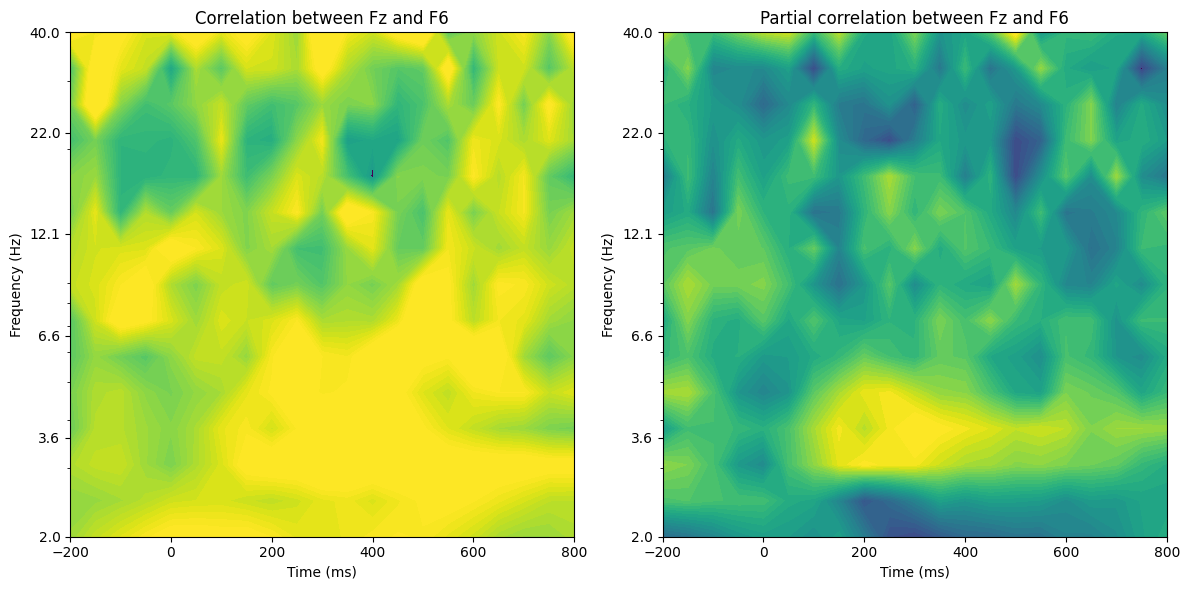

In [ ]:
# Define channels and parameters
seed_chan = 'Fz'
target_chan = 'F6'
control_chan = 'F1'

clim = [0, 0.6]

# Wavelet parameters
min_freq = 2
max_freq = 40
num_frex = 15

# Downsampled times
times2save = np.arange(-200, 850, 50)
# times2save = EEG['times'][0]

# Other wavelet parameters
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
time = np.arange(-1, 1 + 1/EEG['srate'][0, 0], 1/EEG['srate'][0, 0])
half_of_wavelet_size = (len(time) - 1) // 2

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1
wavelet_cycles = 4.5

times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])

# FFT of data for seed, target, and control channels
fft_data_seed = fft(EEG['data'][EEG['chanlocs'][0]['labels']==seed_chan, :, :].flatten('F'), n_convolution)
fft_data_trgt = fft(EEG['data'][EEG['chanlocs'][0]['labels']==target_chan, :, :].flatten('F'), n_convolution)
fft_data_ctrl = fft(EEG['data'][EEG['chanlocs'][0]['labels']==control_chan, :, :].flatten('F'), n_convolution)

# Initialize output time-frequency data
tf_corrdata = np.zeros((len(frequencies), len(times2save), 2))

for fi, freq in enumerate(frequencies):
    # Create wavelet and get its FFT
    fft_wavelet = fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * freq)) ** 2)) / freq, n_convolution)
    
    # Convolution for seed, target, and control sites (save only power)
    conv_result_seed = np.abs(np.reshape(ifft(fft_wavelet * fft_data_seed, n_convolution)[half_of_wavelet_size: -half_of_wavelet_size], (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    conv_result_trgt = np.abs(np.reshape(ifft(fft_wavelet * fft_data_trgt, n_convolution)[half_of_wavelet_size: -half_of_wavelet_size], (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    conv_result_ctrl = np.abs(np.reshape(ifft(fft_wavelet * fft_data_ctrl, n_convolution)[half_of_wavelet_size: -half_of_wavelet_size], (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    
    # Downsample and rank transform all data
    conv_result_seed = rankdata(conv_result_seed[times2saveidx, :], axis=1)
    conv_result_trgt = rankdata(conv_result_trgt[times2saveidx, :], axis=1)
    conv_result_ctrl = rankdata(conv_result_ctrl[times2saveidx, :], axis=1)
    
    for ti, time_idx in enumerate(times2saveidx):

        # Compute bivariate correlations
        r_st = 1 - 6 * np.sum((conv_result_seed[ti, :] - conv_result_trgt[ti, :]) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))
        r_sc = 1 - 6 * np.sum((conv_result_seed[ti, :] - conv_result_ctrl[ti, :]) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))
        r_tc = 1 - 6 * np.sum((conv_result_ctrl[ti, :] - conv_result_trgt[ti, :]) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))
        
        # Bivariate correlation for comparison
        tf_corrdata[fi, ti, 0] = r_st
        
        # Compute partial correlation and store in results matrix
        tf_corrdata[fi, ti, 1] = (r_st - r_sc * r_tc) / (np.sqrt(1 - r_sc ** 2) * np.sqrt(1 - r_tc ** 2))

# Plot
plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.contourf(times2save, frequencies, tf_corrdata[:, :, i], 40, cmap='viridis', extend='both')
    plt.clim(clim)
    plt.xlim([-200, 800])
    plt.yscale('log')
    plt.yticks(np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6), 1), np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6), 1))
    if i == 0:
        plt.title(f'Correlation between {seed_chan} and {target_chan}')
    else:
        plt.title(f'Partial correlation between {seed_chan} and {target_chan}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

### Figure 27.8

Re-run the code for the previous figure but comment out the following line towards the top:

`times2save = EEG['times'][0] # uncomment this line for figure 27.8`

Then run this section of code.

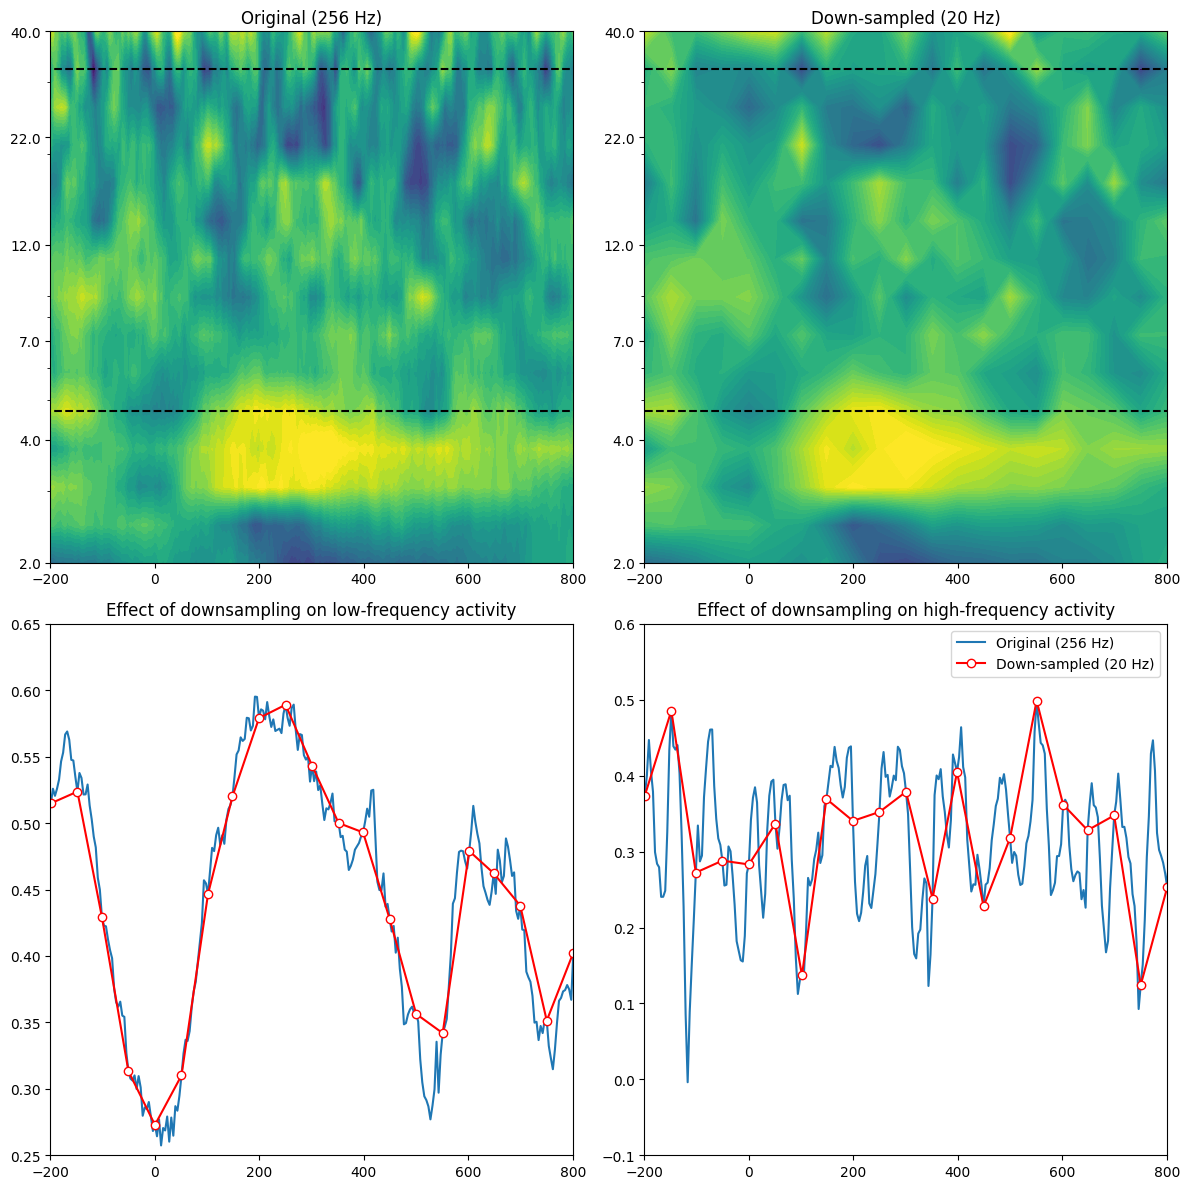

In [ ]:
# Downsample the time series
ds_timesidx = np.array([np.argmin(np.abs(times2save - t)) for t in np.arange(-200, 850, 50)])  # Downsampled times
lofreq = np.argmin(np.abs(frequencies - 4.7))
hifreq = np.argmin(np.abs(frequencies - 32))

plt.figure(figsize=(12, 12))

# Original (256 Hz) time-frequency plot
plt.subplot(221)
plt.contourf(times2save, frequencies, tf_corrdata[:, :, 1], 40, cmap='viridis', extend='both')
plt.plot(times2save, [frequencies[lofreq]] * len(times2save), 'k--')
plt.plot(times2save, [frequencies[hifreq]] * len(times2save), 'k--')
plt.clim(clim)
plt.xlim([-200, 800])
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)), np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)))
plt.title('Original (256 Hz)')

# Downsampled (20 Hz) time-frequency plot
plt.subplot(222)
plt.contourf(times2save[ds_timesidx], frequencies, tf_corrdata[:, ds_timesidx, 1], 40, cmap='viridis', extend='both')
plt.plot(times2save[ds_timesidx], [frequencies[lofreq]] * len(times2save[ds_timesidx]), 'k--')
plt.plot(times2save[ds_timesidx], [frequencies[hifreq]] * len(times2save[ds_timesidx]), 'k--')
plt.clim(clim)
plt.xlim([-200, 800])
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)), np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)))
plt.title('Down-sampled (20 Hz)')

# Effect of downsampling on low-frequency activity
plt.subplot(223)
plt.plot(times2save, tf_corrdata[lofreq, :, 1])
plt.plot(times2save[ds_timesidx], tf_corrdata[lofreq, ds_timesidx, 1], 'ro-', markerfacecolor='w')
plt.xlim([-200, 800])
plt.ylim([0.25, 0.65])
plt.title('Effect of downsampling on low-frequency activity')

# Effect of downsampling on high-frequency activity
plt.subplot(224)
plt.plot(times2save, tf_corrdata[hifreq, :, 1])
plt.plot(times2save[ds_timesidx], tf_corrdata[hifreq, ds_timesidx, 1], 'ro-', markerfacecolor='w')
plt.xlim([-200, 800])
plt.ylim([-0.1, 0.6])
plt.title('Effect of downsampling on high-frequency activity')
plt.legend(['Original (256 Hz)', 'Down-sampled (20 Hz)'])

plt.tight_layout()
plt.show()